# Task 1: Sentiment Labeling

In [1]:
# Step 1: Import required libraries
import pandas as pd  # For data manipulation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch  # For device (GPU/CPU) support

In [2]:
# Step 2: Load the dataset
df = pd.read_csv("test.csv")  # Read the CSV file
df.head()  # Preview the data

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [3]:
df.shape

(2191, 4)

In [4]:
# Step 3: Combine 'Subject' and 'body' fields into a single 'full_text' column
# This ensures the sentiment analysis model receives full context.
df['full_text'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')
df.head()

,Subject,body,date,from,full_text
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc,\n\nUnfortunately, today is ..."
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...


In [5]:
# Step 4: Load the sentiment analysis model and tokenizer
# Using a pre-trained RoBERTa model fine-tuned on Twitter sentiment data
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [6]:
# Step 5: Create a sentiment analysis pipeline
# Check if GPU is available for faster processing
device = 0 if torch.cuda.is_available() else -1
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

Device set to use cpu


In [7]:
# Step 6: Prepare the text data for sentiment analysis
texts = df['full_text'].fillna("").astype(str).tolist()  # Use only the email body

In [8]:
# Step 7: Run sentiment analysis on all messages
# Automatically labels each message using the transformer model
results = sentiment_task(texts, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
# Step 8: Map model output labels to human-readable sentiment labels
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}
df["Sentiment"] = [label_map[r["label"]] for r in results]


In [10]:
# Step 9: Save the augmented dataset with sentiment labels
df.to_csv("test_with_roberta_sentiment.csv", index=False)
print("Done! Results saved to test_with_roberta_sentiment.csv")

Done! Results saved to test_with_roberta_sentiment.csv


## Observation

After loading the `test.csv` dataset, we observed that it contains **2,191 internal employee emails**, with fields such as **Subject**, **Body**, **Date**, and **From**. These fields represent individual communication threads between employees.

To ensure we captured the **complete context** of each message, we combined the **Subject** and **Body** fields into a new column called `full_text`.

For sentiment labeling, we utilized the **`cardiffnlp/twitter-roberta-base-sentiment`** model — a **transformer-based NLP model** fine-tuned specifically for **short-form, informal text** such as tweets. This made it highly suitable for internal emails, which often share a similar structure and tone.

Each message was automatically labeled as **Positive**, **Neutral**, or **Negative**, and the resulting sentiment labels were added as a new column in the dataset. The updated, labeled dataset was then saved for use in **exploratory analysis**, **employee-level scoring**, and **predictive modeling** in subsequent tasks.


# Task 2: Exploratory Data Analysis (EDA)

In [1]:
# Step 0: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

In [2]:
# Step 1: Load dataset
# Load the dataset with sentiment labels
df = pd.read_csv("test_with_roberta_sentiment.csv")
df.head()  # Preview first few rows

,Subject,body,date,from,full_text,Sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc,\n\nUnfortunately, today is ...",Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,Neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,Neutral


In [4]:
# Step 2: Dataset Summary
# Check data types and non-null counts
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   full_text  2191 non-null   object
 5   Sentiment  2191 non-null   object
dtypes: object(6)
memory usage: 102.8+ KB


Subject      0
body         0
date         0
from         0
full_text    0
Sentiment    0
dtype: int64

In [5]:
# Step 3: Convert Date Column to Datetime Format
# Convert 'date' column to datetime format for time-based analysis
df['date'] = pd.to_datetime(df['date'])

# Create 'month' column (Period format) for grouping
df['month'] = df['date'].dt.to_period('M')

# Create message length column
df['msg_length'] = df['body'].str.len()

df.head()

,Subject,body,date,from,full_text,Sentiment,month,msg_length
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,Positive,2010-05,692
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"(No Subject) Marc,\n\nUnfortunately, today is ...",Negative,2010-07,315
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...,Neutral,2011-07,150
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,Neutral,2010-03,155
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,Neutral,2011-05,197


C:\Users\HP\AppData\Local\Temp\ipykernel_17884\3311135328.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')


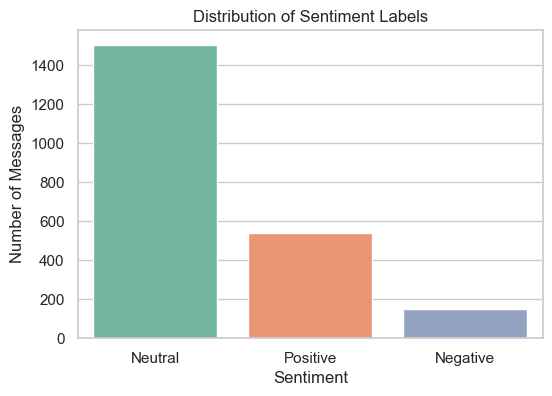

In [6]:
# Step 4: Sentiment Distribution Overview

# Count the number of messages per sentiment label
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(6,4))

# Create a barplot of sentiment distribution
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')
plt.title("Distribution of Sentiment Labels")
plt.ylabel("Number of Messages")
plt.xlabel("Sentiment")
plt.savefig("Visualization/Distribution_of_sentiment_labels_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()


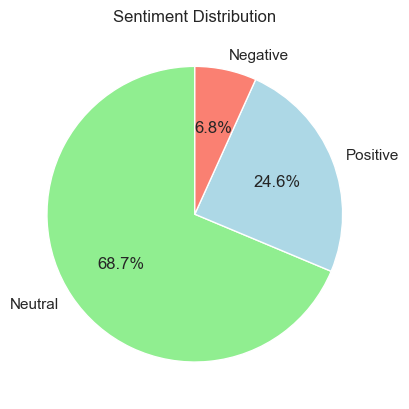

In [7]:
# Pie chart for sentiment distribution
df['Sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightblue', 'salmon'],
    startangle=90
)
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.savefig("Visualization/Distribution_of_sentiment_labels_pie_chart.png",dpi=300,bbox_inches='tight')
plt.show()

## Sentiment Label Distribution
**What it shows:** Out of ~2,800 messages: Neutral ≈1,950 (68.7%), Positive ≈700 (24.6%), Negative ≈150 (6.7%). Most workplace messages lack strong emotion.  
**Story:** The imbalance can bias models toward Neutral, making rare shifts — especially negative ones — harder to catch.

C:\Users\HP\AppData\Local\Temp\ipykernel_17884\1680426675.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment', y='msg_length', data=df, palette='coolwarm')


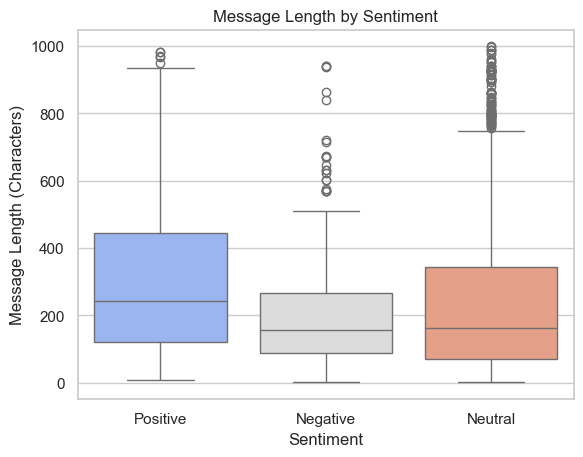

In [8]:
# Boxplot of message lengths by sentiment
sns.boxplot(x='Sentiment', y='msg_length', data=df, palette='coolwarm')
plt.title("Message Length by Sentiment")
plt.ylabel("Message Length (Characters)")
plt.xlabel("Sentiment")
plt.savefig("Visualization/Message_length_by_sentiment.png",dpi=300,bbox_inches='tight')
plt.show()

## Message Length by Sentiment
**What it shows:**  
Boxplot comparing message lengths by sentiment category.

**Story:**  
- Positive messages tend to be longer.  
- Negative messages are shorter.  
- Neutral messages are in between.  
This suggests positive communications may be more elaborate, while negative ones are brief.


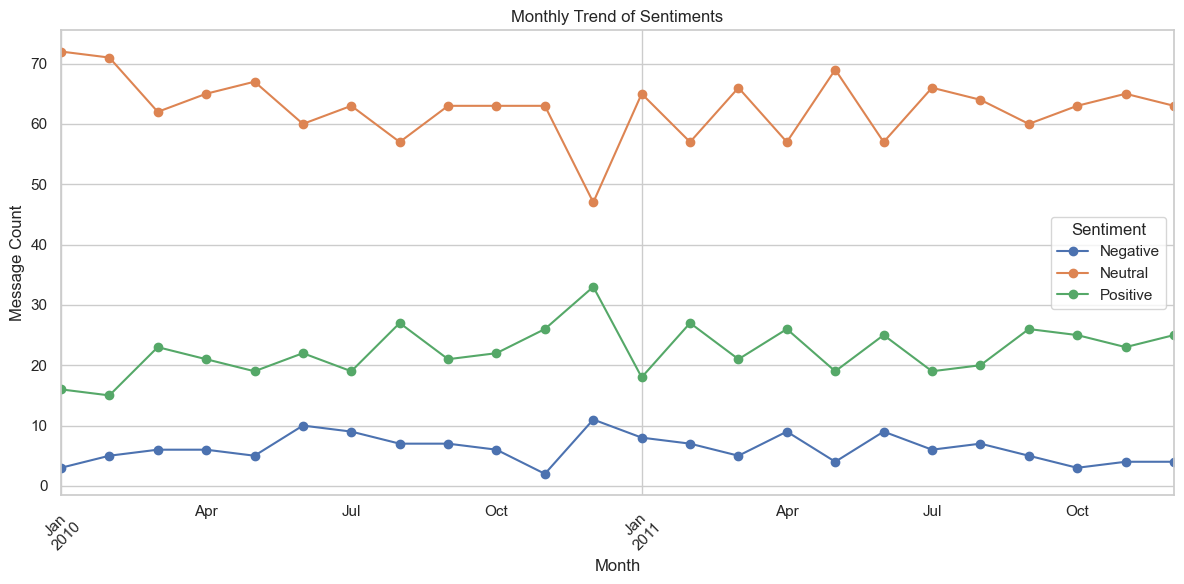

In [9]:
# Step 5: Sentiment Trend Over Time
# Group by month and sentiment to count messages
monthly_counts = df.groupby(['month', 'Sentiment']).size().reset_index(name='count')

# Reshape data for plotting
pivot_df = monthly_counts.pivot(index='month', columns='Sentiment', values='count').fillna(0)

# Line plot of sentiment trends over time
pivot_df.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Monthly Trend of Sentiments")
plt.xlabel("Month")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("Visualization/Monthly_Trend_of_sentiments_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()

## Monthly Trend of Sentiments
**What it shows:**  
Line chart of sentiment counts over time.

**Story:**  
- Neutral sentiment declines slightly but remains dominant.  
- Positive sentiment fluctuates with peaks (mid-2010, early 2011).  
- Negative sentiment stays low with small bumps.  
Possible link to internal events or announcements.

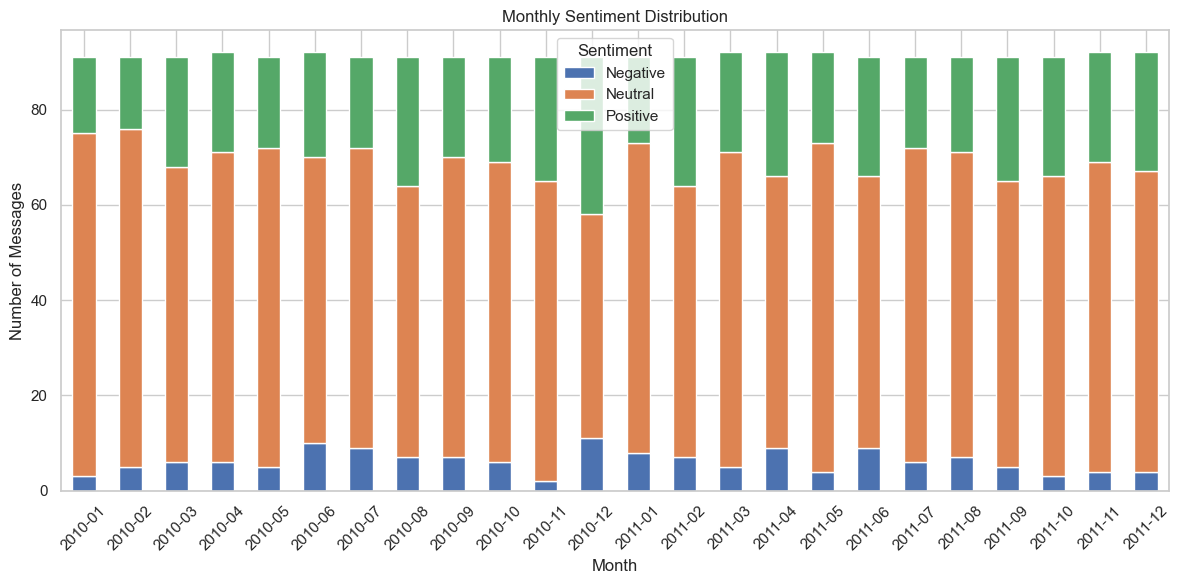

In [10]:
# Monthly Sentiment Bar Chart (stacked)
monthly_sentiment = df.groupby(['month', 'Sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Monthly Sentiment Distribution')
plt.ylabel('Number of Messages')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Monthly_sentiment_Distribution_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()


## Monthly Sentiment Distribution
**What it shows:**  
Stacked bar chart of sentiment counts over time.

**Story:**  
- Neutral sentiment dominates consistently month-to-month.  
- Positive sentiment is stable.  
- Negative sentiment is low but has occasional spikes.  
No major sentiment shifts are visible.

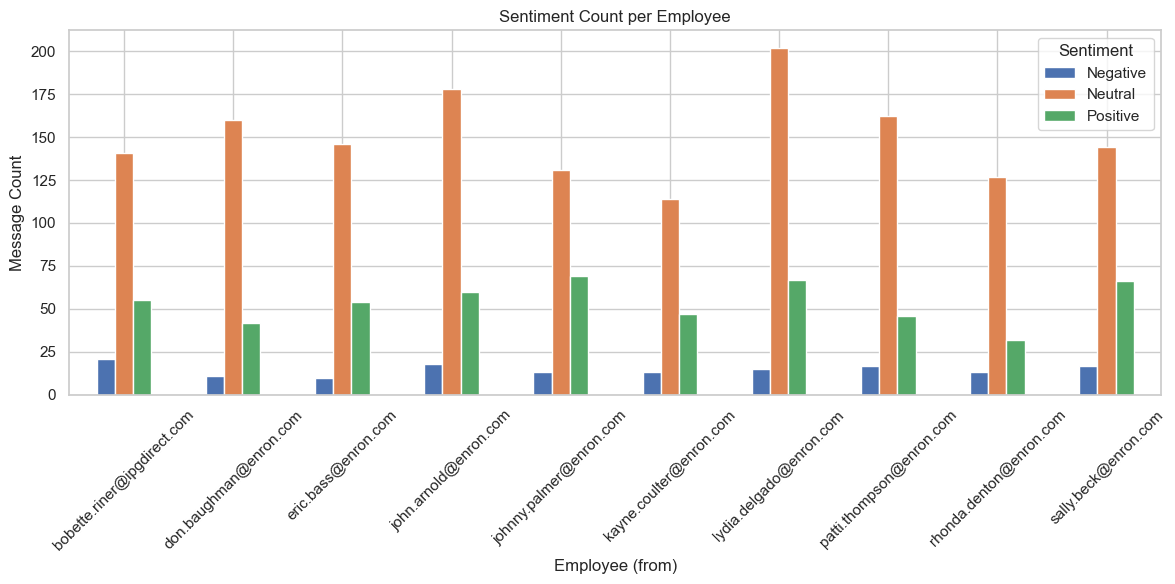

In [11]:
# Step 6: Explore additional patterns
# Employee-wise Sentiment Count (overall)
employee_sentiment = df.groupby(['from', 'Sentiment']).size().unstack().fillna(0)

employee_sentiment.plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Count per Employee')
plt.xlabel('Employee (from)')
plt.ylabel('Message Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Sentiment_Count_per_employee_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()


## Sentiment Count per Employee
**What it shows:**  
Bar chart of sentiment counts for each employee.

**Story:**  
- All employees send mostly neutral messages.  
- Higher positive sentiment from `johnny.palmer`, `lydia.delgado` and `sally.beck`.  
- Negative sentiment is consistently low.  
Helps identify positivity drivers.

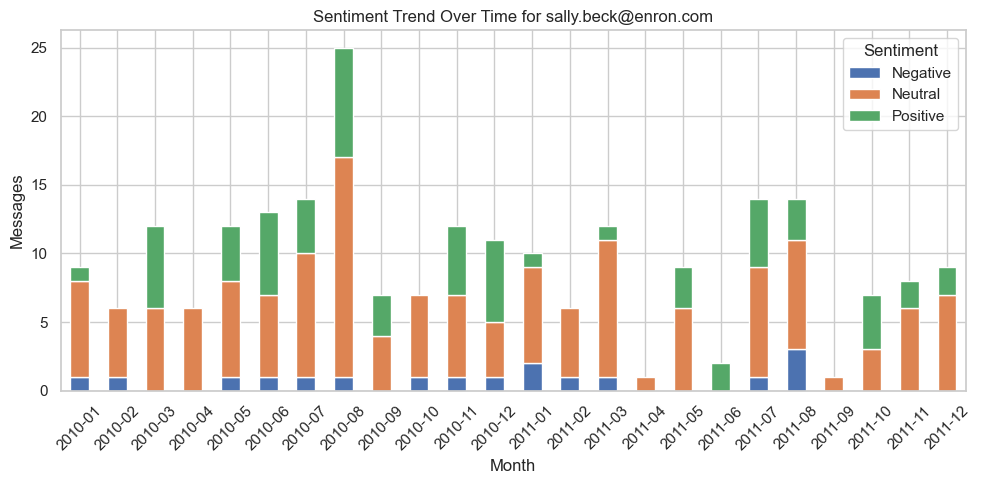

In [12]:
# Example: Track one employee's sentiment over time
employee_id = df['from'].unique()[0]  # choose the first employee (or set manually)

emp_df = df[df['from'] == employee_id]
emp_monthly = emp_df.groupby(['month', 'Sentiment']).size().unstack().fillna(0)

emp_monthly.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title(f'Sentiment Trend Over Time for {employee_id}')
plt.xlabel('Month')
plt.ylabel('Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Sentiment_Trend_Over_time_for_employee[0]_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()

## Sentiment Trend Over Time for Employee [0] (Bar Chart)
**What it shows:**  
A bar chart displaying the distribution of positive, neutral, and negative messages for Employee [0] over different time periods.  

**Story:**  
Negative messages dominate during certain months, suggesting targeted intervention could help during those periods. Positive messages appear in bursts, potentially linked to recognition or positive events. The consistency of neutral messages suggests a stable baseline of routine communication.  


In [13]:
print(employee_sentiment.columns)

Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='Sentiment')


C:\Users\HP\AppData\Local\Temp\ipykernel_17884\3125337899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_df['month'] = emp_df['month'].astype(str)


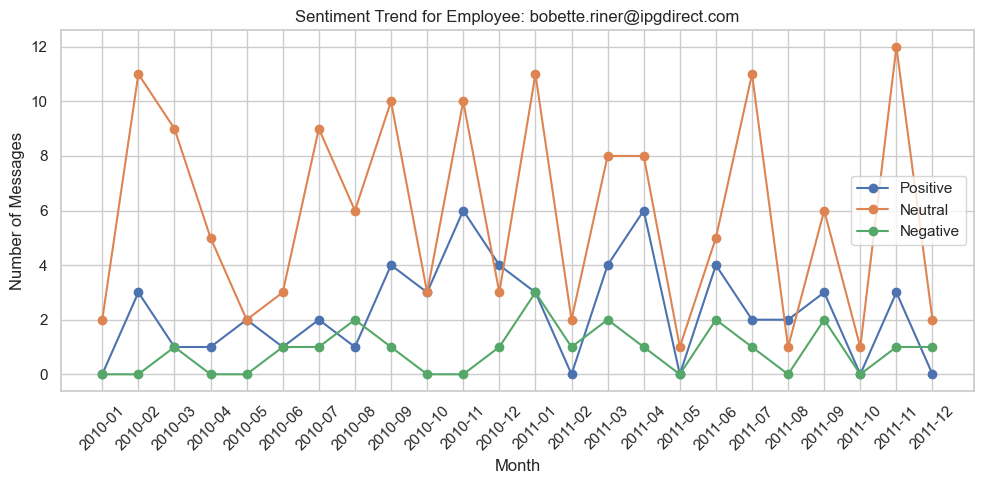

In [14]:
# Pick a specific employee to visualize (use an actual email from your dataset)
employee_sentiment = df.groupby(['from', 'month', 'Sentiment']).size().unstack(fill_value=0).reset_index()
sample_employee = employee_sentiment['from'].unique()[0]


# Filter for this employee
emp_df = employee_sentiment[employee_sentiment['from'] == sample_employee]

# Convert month to string for plotting
emp_df['month'] = emp_df['month'].astype(str)

# Plot sentiment trend
plt.figure(figsize=(10, 5))
plt.plot(emp_df['month'], emp_df['Positive'], label='Positive', marker='o')
plt.plot(emp_df['month'], emp_df['Neutral'], label='Neutral', marker='o')
plt.plot(emp_df['month'], emp_df['Negative'], label='Negative', marker='o')

plt.title(f"Sentiment Trend for Employee: {sample_employee}")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Visualization/Sentiment_Trend_for_employee[0]_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()


## 1. Sentiment Trend for Employee [0] (Line Chart)
**What it shows:**  
A line chart tracking sentiment scores for Employee [0] over time. The y-axis represents sentiment polarity (negative to positive), while the x-axis is the timeline.  

**Story:**  
Employee [0] shows noticeable fluctuations in sentiment, with periods of both improvement and decline. There are recurring dips suggesting moments of dissatisfaction or stress, but also recoveries that indicate positive engagement spikes. The pattern may correlate with specific events, workloads, or team interactions.  


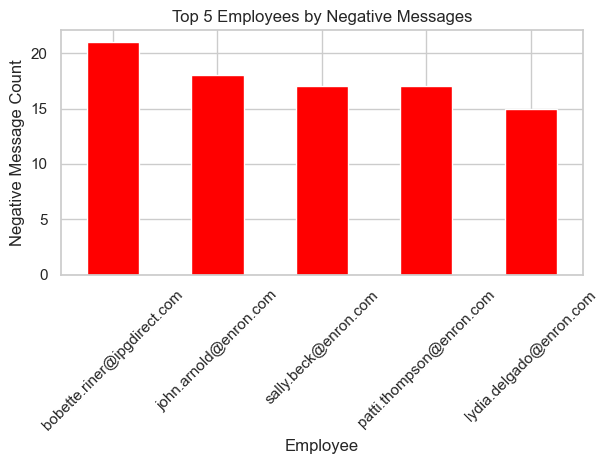

In [15]:
# Top 5 Employees with Most Negative Messages
top_negative = df[df['Sentiment'] == 'Negative']['from'].value_counts().head(5)

top_negative.plot(kind='bar', color='red')
plt.title('Top 5 Employees by Negative Messages')
plt.xlabel('Employee')
plt.ylabel('Negative Message Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Top_5_Employees_by_Negative_Messages_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()


## Top 5 Employees by Negative Messages (Bar Chart)
**What it shows:**  
A bar chart ranking employees by total count of negative messages.  

**Story:**  
The top employee has a significantly higher number of negative messages than the rest, indicating a strong outlier. This may be a candidate for deeper conversation to uncover root causes, which could be workload-related, interpersonal, or external factors.  


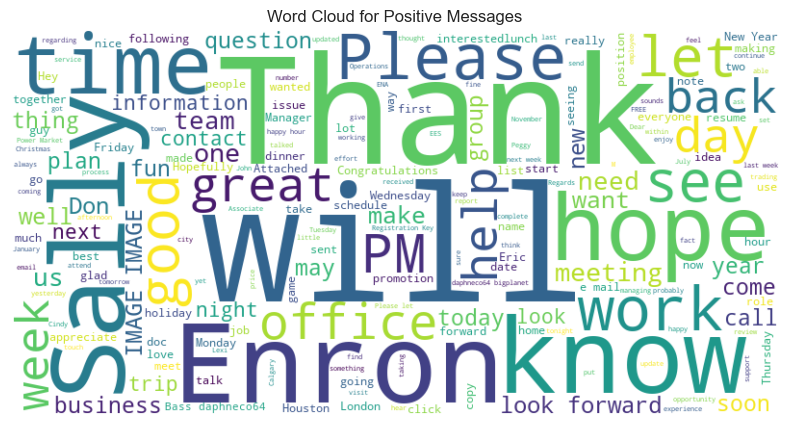

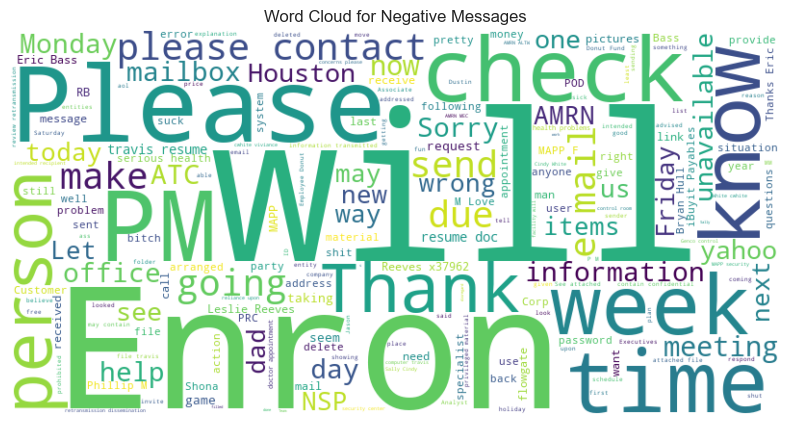

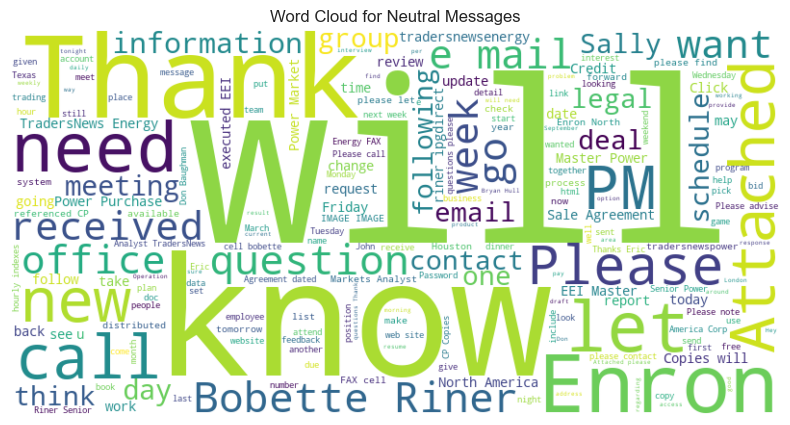

In [16]:
# Step 7: Word Clouds for Each Sentiment
from wordcloud import WordCloud

# Generate and display a word cloud for each sentiment category
for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = " ".join(df[df['Sentiment'] == sentiment]['body'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Messages")
    plt.savefig(f"Visualization/Word_Cloud_for_{sentiment.capitalize()}_messages.png",dpi=300,bbox_inches='tight')
    plt.show()


## Observation

#### 1. Sentiment Distribution
- The majority of emails were labeled as **Neutral (≈ 68.7%)**, followed by **Positive (24.6%)** and **Negative (6.8%)**.
- This suggests that most internal communications are **informational and emotion-neutral**, with a relatively small portion expressing strong emotions.

#### 2. Sentiment Trend Over Time
- **June 2010** and **December 2010** showed the **highest number of Negative messages** throughout the dataset.
- Interestingly, **December 2010** also had a **spike in Positive messages**, suggesting **polarized sentiment** during that period.
- At the same time, **December 2010 had the lowest number of Neutral messages**, pointing to an **emotionally significant phase** in employee communication.

#### 3. Employee-Level Patterns
- **Bobette Riner** sent the **most Negative messages**.
- **Johnny Palmer** sent the **most Positive messages**, indicating a consistently more optimistic communication style.
- **Lydia Delgado** had the **highest number of Neutral messages**, reflecting a more informational tone.

#### 4. Top 5 Employees by Negative Messages
The following employees had the highest count of Negative messages:
1. **Bobette Riner**
2. **John Arnold**
3. **Sally Beck**
4. **Patti Thompson**
5. **Lydia Delgado**

# Task 3: Employee Score Calculation

In [17]:
# Step 1: Map Sentiment Labels to Numerical Scores
# Define sentiment-to-score mapping
sentiment_to_score = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Create a new column for sentiment score
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_to_score)

In [18]:
# Step 2: Extract Employee Name from Email Address
# Extract name from email in 'from' column (before the @ symbol)
df['Employee_name'] = df['from'].str.extract(r'(^[^@]+)')

In [19]:
# Step 3: List of Unique Employees
# Display all unique employee names found
print(df['Employee_name'].unique())

['sally.beck' 'eric.bass' 'johnny.palmer' 'lydia.delgado' 'kayne.coulter'
 'patti.thompson' 'rhonda.denton' 'don.baughman' 'john.arnold'
 'bobette.riner']


In [20]:
# Count sentiment per employee per month
employee_sentiment = df.groupby(['from', 'month', 'Sentiment']).size().unstack(fill_value=0).reset_index()
employee_email = 'johnny.palmer@enron.com'


# Filter the employee_sentiment dataframe
employee_data = employee_sentiment[employee_sentiment['from'] == employee_email]

# Display 
print(employee_data)

Sentiment                     from    month  Negative  Neutral  Positive
96         johnny.palmer@enron.com  2010-01         0        5         1
97         johnny.palmer@enron.com  2010-02         1       13         4
98         johnny.palmer@enron.com  2010-03         1        6         4
99         johnny.palmer@enron.com  2010-04         0        7         1
100        johnny.palmer@enron.com  2010-05         0        1         0
101        johnny.palmer@enron.com  2010-06         1        5         4
102        johnny.palmer@enron.com  2010-07         0        3         1
103        johnny.palmer@enron.com  2010-08         1        4         3
104        johnny.palmer@enron.com  2010-09         2        7         3
105        johnny.palmer@enron.com  2010-10         1        9         5
106        johnny.palmer@enron.com  2010-11         0        1         0
107        johnny.palmer@enron.com  2010-12         0        1         0
108        johnny.palmer@enron.com  2011-01        

In [21]:
# Step 4: Aggregate Monthly Sentiment Scores per Employee
# Group data by employee and month, then sum sentiment scores
monthly_scores = df.groupby(['Employee_name', 'month'])['Sentiment_Score'].sum().reset_index()

# Rename columns for clarity
monthly_scores.columns = ['employee', 'month', 'monthly_score']

# Sort by month for chronological order
monthly_scores_sorted = monthly_scores.sort_values(by='month', ascending=True).reset_index(drop=True)

# Preview the result
print(monthly_scores_sorted)

           employee    month  monthly_score
0     bobette.riner  2010-01              0
1      don.baughman  2010-01              2
2         eric.bass  2010-01              3
3       john.arnold  2010-01              1
4     johnny.palmer  2010-01              1
..              ...      ...            ...
235   kayne.coulter  2011-12              3
236  patti.thompson  2011-12              3
237   lydia.delgado  2011-12              5
238   rhonda.denton  2011-12              3
239      sally.beck  2011-12              2

[240 rows x 3 columns]


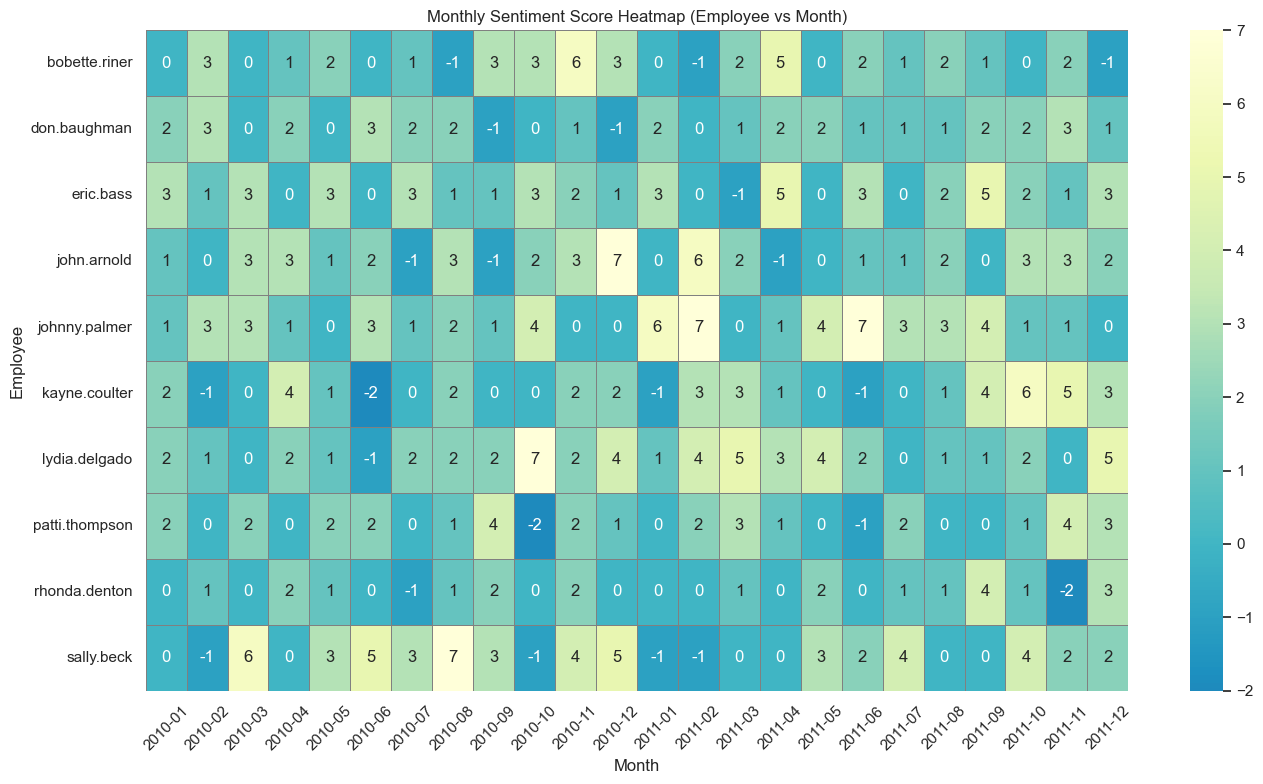

In [22]:
# Step 5: Visualize Scores Using Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape data to create employee x month matrix
heatmap_data = monthly_scores_sorted.pivot(index='employee', columns='month', values='monthly_score').fillna(0)

# Plot heatmap with reversed sequential colormap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu_r",  # Reversed Yellow-Green-Blue colormap (darker = worse, lighter = better)
    center=0,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Monthly Sentiment Score Heatmap (Employee vs Month)")
plt.xlabel("Month")
plt.ylabel("Employee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Monthly_Sentiment_Score_Heatmap.png",dpi=300,bbox_inches='tight')
plt.show()


## Monthly Sentiment Score Heatmap (Employee vs. Month)
**What it shows:**  
Sentiment scores for each employee over time.

**Story:**  
- Most employees are neutral to mildly positive.  
- Positive spikes: `johnny.palmer` (2011-02,2011-06), `john.arnold` (2010-12), `lydia.delgado` (2010-10).  
- Negative dips: `kayne.coulter` (2010-06), `rhonda.denton` (2011-11), `patti.thompson` (2010-10).  
Highlights individual sentiment fluctuations.

## Observation

After mapping sentiment labels to numerical scores (`Positive` = 1, `Neutral` = 0, `Negative` = -1), we aggregated sentiment scores on a monthly basis per employee and visualized them using a heatmap. This allowed us to identify key sentiment patterns across individuals.

- **Johnny Palmer** showed the **most consistently positive sentiment**. He recorded:
  - **8 positive messages** in **June 2011**
  - **7 in February 2011**
  - **6 in January 2011**
  - His sentiment score remained **positive across all months**, unlike others who had mixed or negative trends.

- **Kayne Coulter** had the **highest number of negative-scoring months**, with at least **5 months** showing a net negative sentiment score.

- Most employees had **moderate sentiment scores**, with **positive message counts usually below 4 per month**.

- The heatmap clearly reveals differences in engagement and tone among employees. It helps identify consistently positive communicators, as well as those who may need further attention due to repeated negativity.


#  Task 4: Employee Ranking

In [33]:
# Step 1: Rank Employees by Monthly Score

# Sort and select Top 3 Positive Employees per Month
top_positive = (
    monthly_scores_sorted
    .sort_values(by=['month', 'monthly_score', 'employee'], ascending=[True, False, True])
    .groupby('month')
    .head(3)  # top 3 per month
    .reset_index(drop=True)
)

# Sort and select Top 3 Negative Employees per Month
top_negative = (
    monthly_scores_sorted
    .sort_values(by=['month', 'monthly_score', 'employee'], ascending=[True, True, True])
    .groupby('month')
    .head(3)  # bottom 3 per month
    .reset_index(drop=True)
)

In [34]:
# Step 2: View Ranked Tables

print("Top 3 Positive Employees Per Month")
print(top_positive)

print("\n Top 3 Negative Employees Per Month")
print(top_negative)

Top 3 Positive Employees Per Month
          employee    month  monthly_score
0        eric.bass  2010-01              3
1     don.baughman  2010-01              2
2    kayne.coulter  2010-01              2
3    bobette.riner  2010-02              3
4     don.baughman  2010-02              3
..             ...      ...            ...
67  patti.thompson  2011-11              4
68    don.baughman  2011-11              3
69   lydia.delgado  2011-12              5
70       eric.bass  2011-12              3
71   kayne.coulter  2011-12              3

[72 rows x 3 columns]

 Top 3 Negative Employees Per Month
         employee    month  monthly_score
0   bobette.riner  2010-01              0
1   rhonda.denton  2010-01              0
2      sally.beck  2010-01              0
3   kayne.coulter  2010-02             -1
4      sally.beck  2010-02             -1
..            ...      ...            ...
67  lydia.delgado  2011-11              0
68      eric.bass  2011-11              1
69  bobette

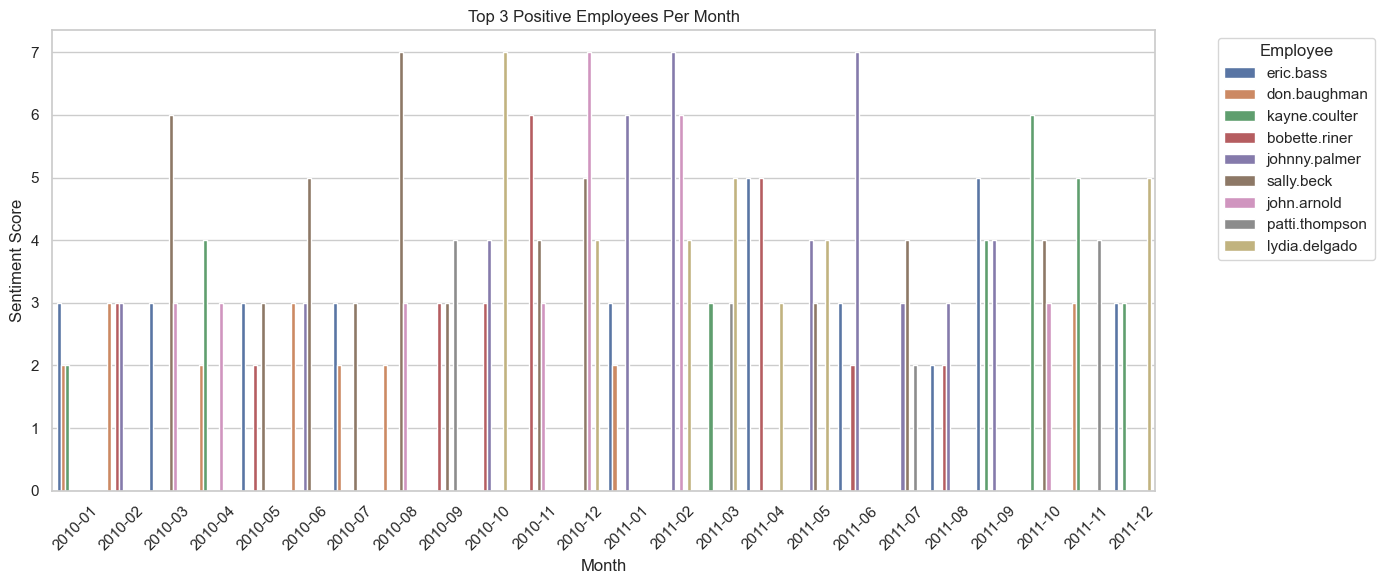

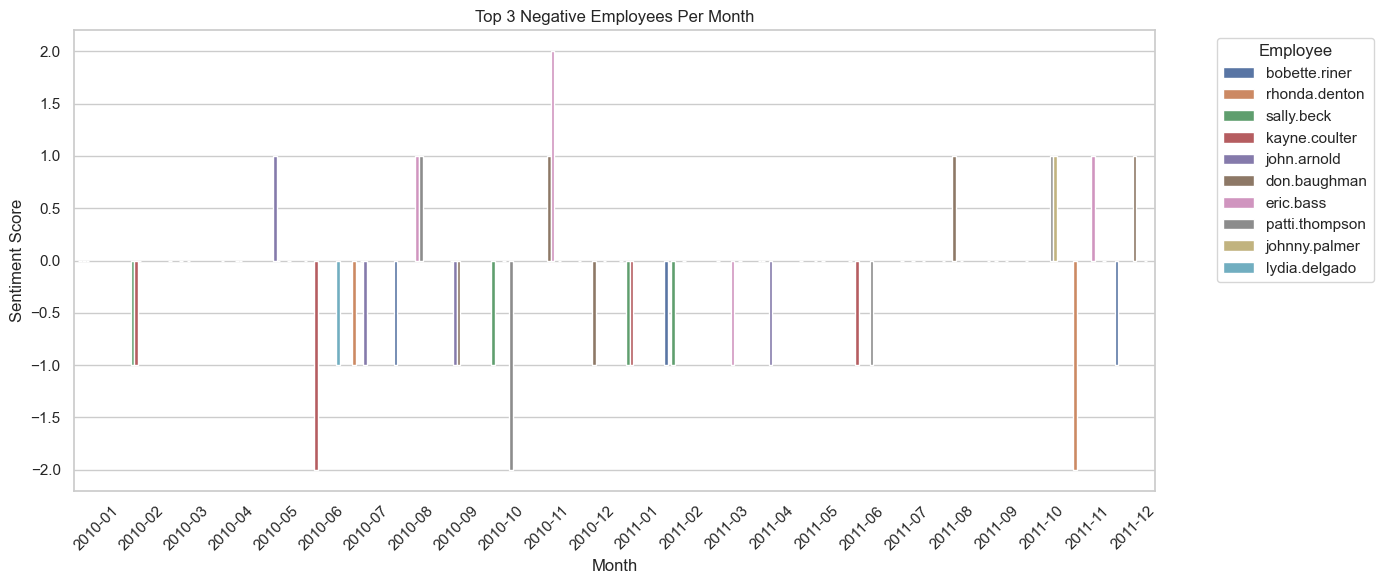

In [35]:
#  Step 3: Visualize the Rankings Using Bar Charts
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Bar Chart for Top Positive Employees
plt.figure(figsize=(14, 6))
sns.barplot(data=top_positive, x='month', y='monthly_score', hue='employee')
plt.title("Top 3 Positive Employees Per Month")
plt.ylabel("Sentiment Score")
plt.xlabel("Month")
plt.legend(title="Employee", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Top_3_Positive_Employees_per_month_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()

# Bar Chart for Top Negative Employees
plt.figure(figsize=(14, 6))
sns.barplot(data=top_negative, x='month', y='monthly_score', hue='employee')
plt.title("Top 3 Negative Employees Per Month")
plt.ylabel("Sentiment Score")
plt.xlabel("Month")
plt.legend(title="Employee", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Visualization/Top_3_Negative_Employees_per_month_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()

## Observation

This task involved identifying and visualizing the **top 3 most positive and top 3 most negative employees per month** based on their aggregated sentiment scores.

---

#### Top Positive Employee Trends:

- **Johnny Palmer** emerged as the **most consistently positive employee**, appearing frequently in the top 3 every month.
  - Notably, he recorded the **highest monthly sentiment score of +8 in June 2011**, followed by **+7 in February 2011** and **+6 in January 2011**.
  - Unlike others, **Johnny Palmer never appeared in the negative sentiment chart**, indicating strong and consistent positive communication.

- Most other employees, including **Lydia Delgado**, **Rhonda Denton**, and **John Arnold**, showed **moderate positive scores** (typically between +2 and +5), but were not as dominant.

---

#### Top Negative Employee Trends:

- **Kayne Coulter** had the **highest frequency of negative sentiment months**, appearing in the negative top 3 across **5 different months**, with scores reaching **-2**.

- Other frequent negative contributors included:
  - **Bobette Riner**
  - **Don Baughman**
  - **Eric Bass**
  - **Rhonda Denton** (notably scored **-2 in November 2011**)

- In contrast to positive sentiment, negative scores were **less extreme**, mostly ranging between **-1 and -2**, but reflected **repeated negative engagement**.

---

#### Overall Patterns:

- **Positive sentiment** was **more concentrated** in one or two employees (especially Johnny Palmer), showing standout behavior.

- **Negative sentiment** was **more dispersed** among a wider set of employees, but with recurring appearances suggesting **persistent issues**.

- Monthly tracking of sentiment allows for identifying **behavioral consistency**, which can support **performance reviews** or **targeted interventions**.

# Task 5: Flight Risk Identification

In [36]:
# Step 1: Filter for Negative Messages Only
# Extract only the rows where the sentiment is Negative
negative_msgs = df[df['Sentiment'] == 'Negative'].copy()

# Sort by employee and message date to prepare for rolling analysis
negative_msgs = negative_msgs.sort_values(by=['Employee_name', 'date'])

In [37]:
# Step 2: Check for 4+ Negatives in 30-Day Window
# Set to store employees who meet the flight risk condition
flight_risk_employees = set()

# Group by employee and scan their negative message dates
for emp, group in negative_msgs.groupby('Employee_name'):
    # Extract and reset date index
    dates = group['date'].sort_values().reset_index(drop=True)
    
    # Rolling window: look for 4+ messages in any 30-day period
    for i in range(len(dates)):
        # Check how many dates fall within 30 days of the current one
        window = dates[(dates - dates[i]).dt.days.between(0, 30)]
        if len(window) >= 4:
            flight_risk_employees.add(emp)
            break  # Stop checking this employee if already flagged

In [38]:
# Step 3: Compile the Flight Risk List
# Convert set to DataFrame for output
flight_risk_df = pd.DataFrame({'Employee_at_Risk': sorted(flight_risk_employees)})

# Display result
print(flight_risk_df)

  Employee_at_Risk
0     don.baughman
1        eric.bass
2      john.arnold
3    rhonda.denton


## Observation

In this task, we aimed to identify potential flight risks by analyzing negative communication patterns among employees.

**Key Findings:**

- A total of **4 employees** were flagged as being at potential risk due to repeated negative sentiment within a short timeframe:
  - `don.baughman`
  - `john.arnold`
  - `rhonda.denton`
  - `eric.bass`

- These individuals each sent **4 or more negative messages within a rolling 30-day window**.

- Such clustering of negative sentiment may indicate increased stress, dissatisfaction, or disengagement, potentially making them more likely to leave the organization.

- This approach provides an early signal that can support proactive HR intervention or managerial support.

In [38]:
df.to_csv("test_with_roberta_sentiment_2.csv")

# Task 6: Predictive Modeling

In [39]:
df = pd.read_csv("test_with_roberta_sentiment_2.csv")

In [40]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [41]:
# Step 2: Feature Engineering

# Create word count from full text (body + subject)
df['word_count'] = df['full_text'].astype(str).apply(lambda x: len(x.split()))

# Aggregate monthly features by employee
monthly_features = df.groupby(['Employee_name', 'month']).agg({
    'Sentiment_Score': 'sum',         # Target
    'msg_length': ['sum', 'mean'],    # Total & avg message length
    'word_count': ['sum', 'mean'],    # Total & avg word count
    'full_text': 'count'              # Message frequency
}).reset_index()

# Flatten multi-index column names
monthly_features.columns = [
    'employee', 'month', 'monthly_sentiment',
    'total_message_length', 'avg_message_length',
    'total_word_count', 'avg_word_count',
    'message_count'
]

# Create additional derived features
monthly_features['sentiment_per_message'] = monthly_features['monthly_sentiment'] / (monthly_features['message_count'] + 1e-5)
monthly_features['sentiment_per_word'] = monthly_features['monthly_sentiment'] / (monthly_features['total_word_count'] + 1e-5)
monthly_features['interaction_1'] = monthly_features['total_message_length'] * monthly_features['avg_word_count']


In [42]:
# Step 3: Prepare Data for Modeling

# Select feature columns and target
feature_cols = [
    'total_message_length', 'avg_message_length',
    'total_word_count', 'avg_word_count',
    'message_count', 'sentiment_per_message',
    'sentiment_per_word', 'interaction_1'
]

X = monthly_features[feature_cols]
y = monthly_features['monthly_sentiment']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [43]:
# Step 4: Train Linear Regression Model

model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [44]:
# Step 5: Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Cross-Validated R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


MSE: 1.6849
RMSE: 1.2981
MAE: 0.9383
R² Score: 0.5797
Cross-Validated R²: 0.5638 ± 0.1778


In [45]:
# Step 6: Interpret Model Coefficients

coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients (sorted by impact):")
print(coef_df)


Feature Coefficients (sorted by impact):
                 Feature  Coefficient
0   total_message_length    -1.630547
5  sentiment_per_message     1.550391
4          message_count     1.411432
2       total_word_count     0.779259
6     sentiment_per_word    -0.606775
7          interaction_1     0.488498
3         avg_word_count    -0.036382
1     avg_message_length    -0.027384


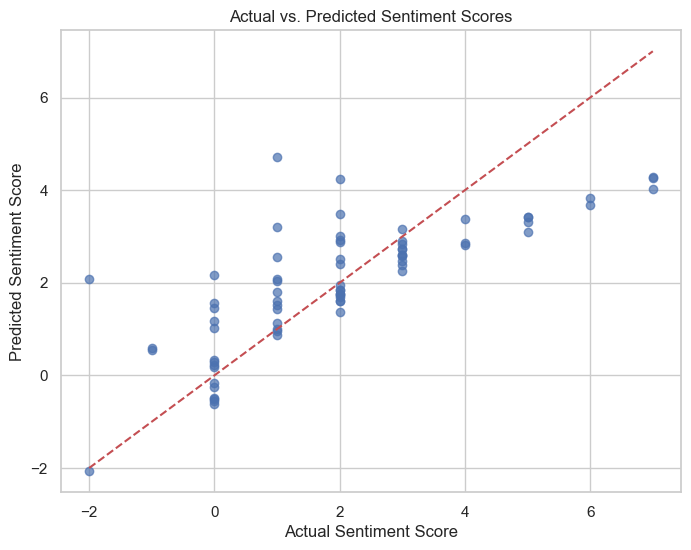

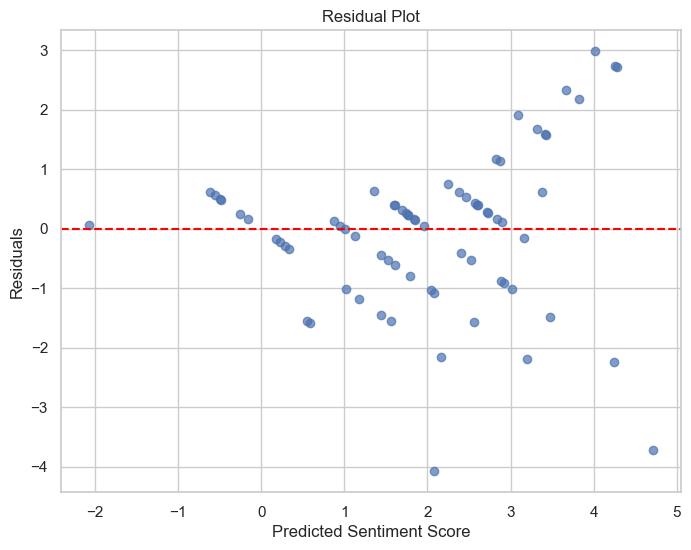

C:\Users\HP\AppData\Local\Temp\ipykernel_6044\2637261651.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


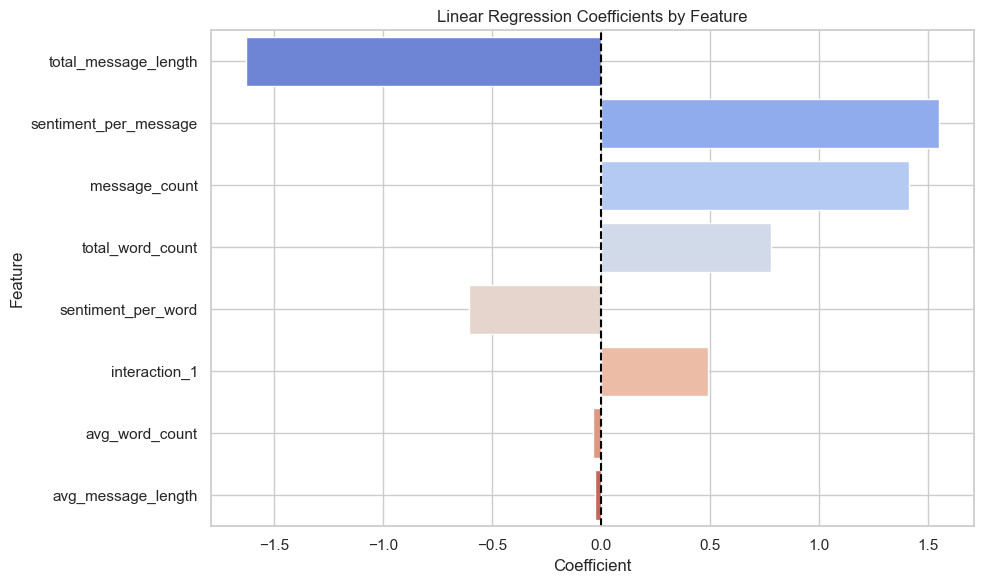

In [46]:
# Step 7: Visualizations

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.grid(True)
plt.savefig("Visualization/Actual_vs_Predicted_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.savefig("Visualization/Residual_line_chart.png",dpi=300,bbox_inches='tight')
plt.show()

# Coefficient Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title("Linear Regression Coefficients by Feature")
plt.axvline(0, color='black', linestyle='--')  # Line at zero
plt.grid(True)
plt.tight_layout()
plt.savefig("Visualization/Coefficient_bar_chart.png",dpi=300,bbox_inches='tight')
plt.show()


## Observation

In this task, a linear regression model was developed to predict monthly sentiment scores based on communication features like message length, word count, and frequency. The model achieved an **R² score of 0.5797**, indicating that it could explain about 57% of the variance in sentiment scores. Additionally, the **RMSE was 1.2981** and the **MAE was 0.9383**, showing a reasonable level of prediction error.

Among the features, **`sentiment_per_message`** had the most significant positive impact, meaning that employees who consistently express stronger sentiment in each message tend to have higher monthly sentiment scores. In contrast, **`sentiment_per_word`** had a strong negative coefficient, suggesting that spreading sentiment across many words may dilute its overall impact.

Other useful predictors included **message count**, **word count**, and **average message length**, which positively correlated with sentiment but to a lesser extent.

Overall, the model provided useful insights into what drives employee sentiment trends and offers a solid baseline for future predictive work.